In [5]:
from sporgboost.forests import *
from sklearn.metrics import roc_auc_score
from get_data import load
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris
from sporgboost.preprocessing import onehot_encode
X, y = load_iris(return_X_y=True)

y = onehot_encode(y)

[Text(0.5, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.444\nsamples = 150\nvalue = [[100, 50]\n[100, 50]\n[100, 50]]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [[0, 50]\n[50, 0]\n[50, 0]]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.333\nsamples = 100\nvalue = [[100, 0]\n[50, 50]\n[50, 50]]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.112\nsamples = 54\nvalue = [[54, 0]\n[5, 49]\n[49, 5]]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.027\nsamples = 48\nvalue = [[48, 0]\n[1, 47]\n[47, 1]]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [[47, 0]\n[0, 47]\n[47, 0]]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[1, 0]\n[0, 1]]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.296\nsamples = 6\nvalue = [[6, 0]\n[4, 2]\n[2, 4]]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [[3, 0]\n[3, 0]\n[0, 

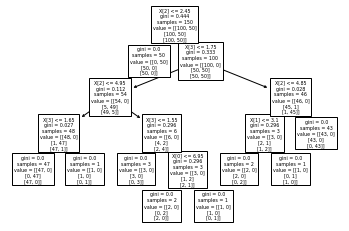

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
sk = DecisionTreeClassifier()
sk.fit(X, y)
plot_tree(sk)

In [7]:
# from sporgboost.common import _grow_tree, _predict_tree
from sporgboost.projections import *
from numba import prange, deferred_type, optional, float64
from numba.experimental import jitclass
from sporgboost.common import best_split, gini_impurity
from sporgboost._arrays import row_mean, row_nunique
import numpy as np
from numba import njit, prange

@njit(parallel = False)
def _grow_tree(X, y, proj, max_depth, *args):
    # Each piece of work contains a pointer to 
    # the node being processed and the index positions
    # of obs at that node
    node_train_idx = {1 : np.arange(0, X.shape[0])}
    
    # To track the information for the nodes and use numba
    # we need to keep homogenous data types, use dicts
    node_value = {}
    node_split = {}
    node_proj = {}

    depth = 0
    max_depth = np.inf if max_depth is None else max_depth

    while (depth <= max_depth) and len(node_train_idx) > 0:
        # Parallel loop over all nodes to be processed
        for _ in prange(len(node_train_idx)):
            # Get node and asociated obs
            node_idx, idx = node_train_idx.popitem()

            X_, y_ = X[idx, :], y[idx, :]

            # Step 1: Check if node is a leaf
            node_value[node_idx] = row_mean(y_).reshape((1, -1))

            # Leaf check 1: at max depth
            if depth == max_depth:
                continue

            # Leaf check 2: partition is pure
            if gini_impurity(node_value[node_idx]) == 0.:
                continue

            # Step 2: If node is not a leaf, find a split
            # Project data based on function
            A = proj(X_, *args)

            X_proj = X_ @ A

            # Leaf check 3: partition has no unique levels in X, can't
            # be partitioned further to improve performance
            if np.all(row_nunique(X_proj) <= 1):
                continue

            # Evaluate each col and candidate split
            col, node_split[node_idx] = best_split(X_proj, y_)
            node_proj[node_idx] = np.ascontiguousarray(A[:, col]).reshape((-1, 1))

            # Initalize children and add to the next iteration to be processed
            node_train_idx[node_idx * 10] = idx[(X_proj[:, col] <= node_split[node_idx])]
            node_train_idx[node_idx * 10 + 1] = idx[(X_proj[:, col] > node_split[node_idx])]
        depth += 1

    return node_value, node_split, node_proj
    # return {'value' : node_value, 'split' : node_split, 'left' : node_left, 'right' : node_right, 'proj' : proj}

tree = _grow_tree(X, y, identity, None)

In [99]:
%timeit  _grow_tree(X, y, identity, None)

In [4]:
%timeit _grow_tree(X, y, identity, None)

1.08 ms ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
# %timeit _grow_tree(X, y, sparse_random, None, 2, 3)

In [4]:
_predict_tree(tree, X, 3)

c:\Users\Ed\OneDrive - Johns Hopkins\Desktop\Adv_ML_Project\sporgboost\common\_predict.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 2d, A))
  X_ = np.dot(X, tree.proj)
c:\Users\Ed\OneDrive - Johns Hopkins\Desktop\Adv_ML_Project\sporgboost\common\_predict.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  out[le, :] = _predict_tree(tree.left, X[le], n_classes)


AttributeError: 'Optional' object has no attribute 'type'

In [ ]:
%timeit _predict_tree(tree, X, 3)

NameError: name '_predict' is not defined

In [4]:
tree = _grow_tree(X, y, proj = identity, max_depth = None)

c:\Users\Ed\OneDrive - Johns Hopkins\Desktop\Adv_ML_Project\sporgboost\common\_grow.py:36: NumbaWarning: Cannot cache compiled function "_grow_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(parallel=True, cache=True)


In [8]:
tree = _grow_tree(X, y, 2, 3, proj = sparse_random, max_depth = None)

TypeError: some keyword arguments unexpected

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=1234)

In [19]:
models = {
    # 'rf' : RandomForest(),
    # 'ab' : AdaBoost(),
    'sporf' : SPORF(d=2, s=3),
    'sporgboost' : SPORGBoost(d=2, s=3, max_depth=2),
    # 'rrf' : RotationalRandomForest(K=2),
    # 'rotboost' : RotBoost(K=2)
}

for k, m in models.items():
    print(f"Fitting {k}")
    m.fit(X_train, y_train)


Fitting sporf
Fitting sporgboost


In [22]:
%time
models['sporgboost'].fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 594 ms
Wall time: 597 ms


RandomForestClassifier()

In [13]:
rf.predict_proba(X_test)

[array([[0.31, 0.69],
        [0.21, 0.79],
        [0.37, 0.63],
        ...,
        [0.33, 0.67],
        [0.32, 0.68],
        [0.51, 0.49]]),
 array([[0.69, 0.31],
        [0.79, 0.21],
        [0.63, 0.37],
        ...,
        [0.67, 0.33],
        [0.68, 0.32],
        [0.49, 0.51]])]

In [14]:
roc_auc_score(y_test, rf.predict_proba(X_test)[1], multi_class='ovo')

0.9192514784504009

In [24]:
from sklearn.metrics import accuracy_score
# accuracy_score(y_test, rf.predict(X_test))

In [26]:
# Get AUC scores
auc = {key : accuracy_score(y_test, model.predict(X_test)) for key, model in models.items() if key in {'sporf','sporgboost'}}
auc

{'sporf': 0.7630681818181818, 'sporgboost': 0.6098863636363636}